In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import kagglehub

In [19]:
try:
    path = kagglehub.dataset_download("kushsheth/uber-ride-price-prediction")
    print("Dataset downloaded to:", path)
except Exception as e:
    print("Error downloading dataset:", e)

Dataset downloaded to: /root/.cache/kagglehub/datasets/kushsheth/uber-ride-price-prediction/versions/1


In [21]:
import pandas as pd
file_path = '/root/.cache/kagglehub/datasets/kushsheth/uber-ride-price-prediction/versions/1/uber.csv'

df = pd.read_csv(file_path)
print(df.head())


   Unnamed: 0      key  fare_amount          pickup_datetime  \
0    24238194  52:06.0          7.5  2015-05-07 19:52:06 UTC   
1    27835199  04:56.0          7.7  2009-07-17 20:04:56 UTC   
2    44984355  45:00.0         12.9  2009-08-24 21:45:00 UTC   
3    25894730  22:21.0          5.3  2009-06-26 08:22:21 UTC   
4    17610152  47:00.0         16.0  2014-08-28 17:47:00 UTC   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.999817        40.738354         -73.999512         40.723217   
1        -73.994355        40.728225         -73.994710         40.750325   
2        -74.005043        40.740770         -73.962565         40.772647   
3        -73.976124        40.790844         -73.965316         40.803349   
4        -73.925023        40.744085         -73.973082         40.761247   

   passenger_count  
0                1  
1                1  
2                1  
3                3  
4                5  


In [22]:
df.dropna(inplace=True)

In [23]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [24]:
df['hour'] = df['pickup_datetime'].dt.hour
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['month'] = df['pickup_datetime'].dt.month

In [25]:
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c
    return km

df['distance_km'] = haversine(df['pickup_longitude'], df['pickup_latitude'],
                              df['dropoff_longitude'], df['dropoff_latitude'])


In [26]:
df = df[(df['fare_amount'] > 0) & (df['distance_km'] > 0)]

In [27]:
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
df['is_rush_hour'] = df['hour'].apply(lambda x: 1 if (7 <= x <= 10) or (16 <= x <= 19) else 0)
df['distance_km_squared'] = df['distance_km'] ** 2


In [28]:
features = ['distance_km', 'distance_km_squared', 'hour', 'day_of_week', 'month', 'is_weekend', 'is_rush_hour']
X = df[features]
y = df['fare_amount']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [30]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'ElasticNet Regression': ElasticNet(alpha=0.1, l1_ratio=0.5)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {'RMSE': rmse, 'R2': r2}


In [31]:
for name, metrics in results.items():
    print(f"{name} - RMSE: {metrics['RMSE']:.4f}, R2: {metrics['R2']:.4f}")


Linear Regression - RMSE: 9.6130, R2: 0.0065
Ridge Regression - RMSE: 9.6130, R2: 0.0065
Lasso Regression - RMSE: 9.6172, R2: 0.0057
ElasticNet Regression - RMSE: 9.6152, R2: 0.0061


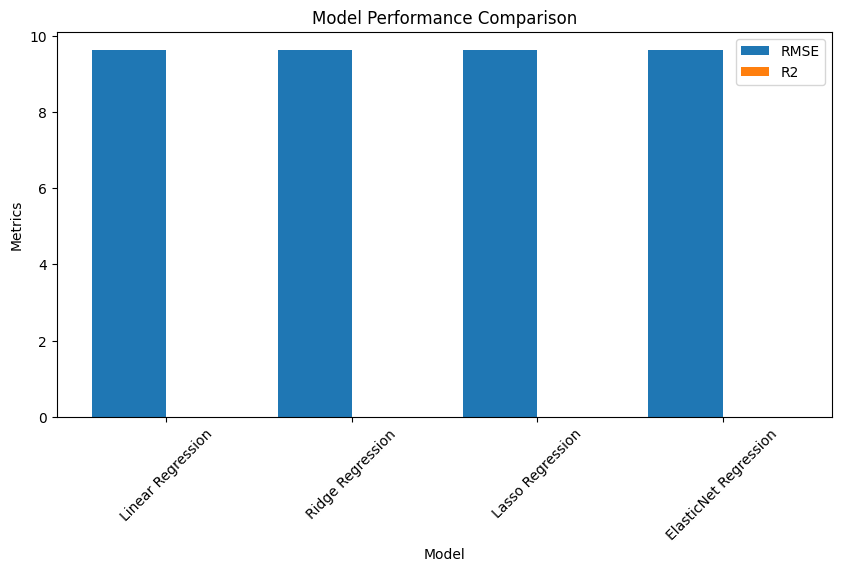

In [32]:
labels = list(results.keys())
rmse_values = [metrics['RMSE'] for metrics in results.values()]
r2_values = [metrics['R2'] for metrics in results.values()]

x = np.arange(len(labels))

plt.figure(figsize=(10, 5))
plt.bar(x - 0.2, rmse_values, 0.4, label='RMSE')
plt.bar(x + 0.2, r2_values, 0.4, label='R2')

plt.xlabel('Model')
plt.ylabel('Metrics')
plt.title('Model Performance Comparison')
plt.xticks(x, labels, rotation=45)
plt.legend()
plt.show()